In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk
import joblib
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,cross_validate
import timeit
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
import sys
from sksurv.metrics import concordance_index_ipcw,concordance_index_censored
from pickle import dump
from sklearn.model_selection import KFold
from sksurv.metrics import (
    as_concordance_index_ipcw_scorer,
    as_cumulative_dynamic_auc_scorer,
    as_integrated_brier_score_scorer,
)

In [2]:
from sksurv.ensemble import RandomSurvivalForest
random_state = 108

In [8]:
train = pd.read_csv("train2.csv",index_col = 0)
#X_train = train.query('death_observed == True or death_in_study == False')
outcome_columns = ['death_in_study','upper_bound',
                       'discharge_status_new','fup_status_30d_new', 'fup_status_12mth_new','lower_bound','death_observed',
                  'event_max','event_min','event_mid','event_observed']
X_train = train.drop(outcome_columns,axis=1)
X_train = X_train.drop(["egfr_pre"],axis=1)

feature_import_prev = pd.read_csv("results/rf_full_feature_importance_final.csv",index_col=0).sort_values("importances_mean",ascending = False)
n_features = 30
features = feature_import_prev.index[:n_features]


In [9]:
from sklearn.preprocessing import StandardScaler

scaler =  StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_train_scale = pd.DataFrame(X_train_scale,columns=X_train.columns,index=train.index)
#X_train_scale = X_train_scale[features]
print(len(X_train_scale.columns))

99


In [10]:

y = train[["death_in_study","event_max" ]]

records = y.to_records(index=False)
y_train = np.array(records, dtype = records.dtype.descr)

In [13]:
from sksurv.metrics import cumulative_dynamic_auc
def calc_dyn_auc(model,X,y,y_train,time_max=365,time_interval=7):
    
    times = np.arange(1e-5, time_max, time_interval)
    chf_funcs = model.predict_cumulative_hazard_function(X, return_array=False)
    risk_scores = np.row_stack([chf(times) for chf in chf_funcs])
    auc, mean_auc = cumulative_dynamic_auc(y, y_train, risk_scores, times)

    return auc, mean_auc,times

In [14]:
def plot_auc(cph_auc,cph_mean_auc,times):
    plt.plot(times, cph_auc, "o-", label=f"Mean AUC = {cph_mean_auc:0.3f})")
    plt.axhline(cph_mean_auc, linestyle="--",color='r')
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.legend(loc="lower center")
    plt.grid(True)

# Random Forest

In [17]:
rsf = RandomSurvivalForest(random_state=random_state,n_estimators=50,max_depth=10)
rsf.fit(X_train_scale, y_train)
rsf_auc, rsf_mean_auc,times = calc_dyn_auc(rsf,X_train_scale,y_train,y_train)

with open("model/rf.pkl", "wb") as f:
    dump(rsf, f, protocol=5)

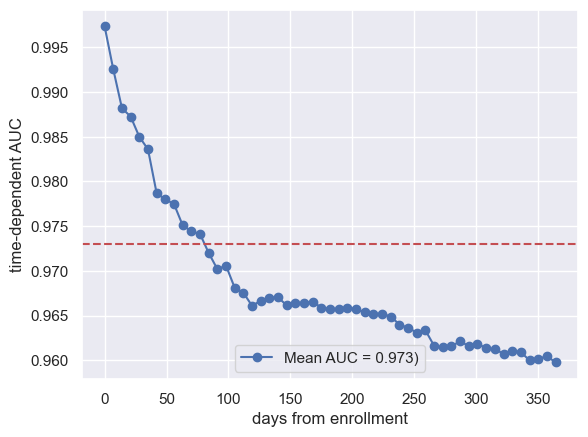

In [18]:
plot_auc(rsf_auc,rsf_mean_auc,times)

In [26]:
times = np.arange(1e-5, 365, 7)
n_folds = 5
cv = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

#old_stdout = sys.stdout
#log_file = open("results/rf_y.log","w+")
#sys.stdout = log_file
cv_param_grid = {
    "estimator__max_depth": np.arange(2, 21,2,dtype=int),
    "estimator__n_estimators": np.arange(50, 201,50,dtype=int),
    #"estimator__min_samples_split": np.arange(10, 31,5,dtype=int)
}
rsf = RandomSurvivalForest(random_state=random_state,
                           #n_estimators=500, 
                           #min_samples_split=10, 
                           #min_samples_leaf=15,
                           max_features = 'sqrt',
                            max_samples=0.8)
                          #max_depth = 10)

gcv_iauc = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(rsf, times=times),
    param_grid=cv_param_grid,
    cv=cv,
    verbose=10,
    return_train_score=True
).fit(X_train_scale, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START estimator__max_depth=2, estimator__n_estimators=50.........
[CV 1/5; 1/40] END estimator__max_depth=2, estimator__n_estimators=50;, score=(train=0.712, test=0.673) total time=   2.2s
[CV 2/5; 1/40] START estimator__max_depth=2, estimator__n_estimators=50.........
[CV 2/5; 1/40] END estimator__max_depth=2, estimator__n_estimators=50;, score=(train=0.715, test=0.687) total time=   2.0s
[CV 3/5; 1/40] START estimator__max_depth=2, estimator__n_estimators=50.........
[CV 3/5; 1/40] END estimator__max_depth=2, estimator__n_estimators=50;, score=(train=0.724, test=0.670) total time=   2.1s
[CV 4/5; 1/40] START estimator__max_depth=2, estimator__n_estimators=50.........
[CV 4/5; 1/40] END estimator__max_depth=2, estimator__n_estimators=50;, score=(train=0.741, test=0.627) total time=   2.1s
[CV 5/5; 1/40] START estimator__max_depth=2, estimator__n_estimators=50.........
[CV 5/5; 1/40] END estimator__max_depth=2

In [50]:
#sys.stdout = old_stdout
#log_file.close()

In [27]:
pd.DataFrame(gcv_iauc.cv_results_).to_csv("results/rf_event_max_cv_results_.csv")

In [28]:
pd.DataFrame(gcv_iauc.cv_results_).sort_values("mean_test_score",ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,param_estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
11,16.446843,0.158191,1.892850,0.195037,6,200,"{'estimator__max_depth': 6, 'estimator__n_esti...",0.694991,0.687689,0.689363,...,0.690018,0.027712,1,0.854615,0.857529,0.838160,0.833829,0.839227,0.844672,0.009527
10,12.479446,0.275268,1.393138,0.163144,6,150,"{'estimator__max_depth': 6, 'estimator__n_esti...",0.692481,0.683078,0.689822,...,0.687340,0.025720,2,0.852372,0.855784,0.842505,0.833317,0.837402,0.844276,0.008584
13,10.798001,0.047962,0.930305,0.118269,8,100,"{'estimator__max_depth': 8, 'estimator__n_esti...",0.687200,0.695462,0.682095,...,0.686900,0.021514,3,0.902806,0.912601,0.906478,0.899694,0.902932,0.904902,0.004408
9,8.216158,0.188180,0.917466,0.129863,6,100,"{'estimator__max_depth': 6, 'estimator__n_esti...",0.689990,0.685187,0.684880,...,0.686703,0.025130,4,0.849206,0.853374,0.840137,0.833744,0.832783,0.841848,0.008219
24,8.901288,0.133806,0.503860,0.050747,14,50,"{'estimator__max_depth': 14, 'estimator__n_est...",0.696321,0.675159,0.689974,...,0.686484,0.024131,5,0.980021,0.984027,0.980903,0.977021,0.983120,0.981018,0.002468
7,11.308335,0.159341,1.888243,0.258233,4,200,"{'estimator__max_depth': 4, 'estimator__n_esti...",0.694721,0.690495,0.680745,...,0.686183,0.028543,6,0.783956,0.787841,0.775519,0.788274,0.781637,0.783445,0.004669
5,5.660059,0.068753,0.916042,0.109659,4,100,"{'estimator__max_depth': 4, 'estimator__n_esti...",0.694861,0.690037,0.683923,...,0.685907,0.027408,7,0.776778,0.777738,0.769065,0.786564,0.773892,0.776807,0.005736
15,21.853793,0.207246,2.190492,0.647175,8,200,"{'estimator__max_depth': 8, 'estimator__n_esti...",0.690923,0.690502,0.680843,...,0.685603,0.023014,8,0.911829,0.917766,0.905144,0.896208,0.903964,0.906982,0.007326
14,16.542035,0.353741,1.504225,0.179127,8,150,"{'estimator__max_depth': 8, 'estimator__n_esti...",0.690358,0.694767,0.678473,...,0.685383,0.021544,9,0.907140,0.917248,0.907156,0.897192,0.905901,0.906928,0.006363
27,35.457814,0.301698,2.093313,0.496673,14,200,"{'estimator__max_depth': 14, 'estimator__n_est...",0.687730,0.681441,0.690569,...,0.684528,0.015040,10,0.984978,0.988323,0.984884,0.982101,0.985239,0.985105,0.001973


In [29]:
def plot_grid_search_results(gcv, ax, name, param = "max_depth"):
    ax.errorbar(
        x=gcv.cv_results_["param_estimator__{}".format(param)].filled(),
        y=gcv.cv_results_["mean_test_score"],
        yerr=gcv.cv_results_["std_test_score"],
    )
    ax.plot(
        gcv.best_params_["estimator__{}".format(param)],
        gcv.best_score_,
        "ro",
    )
    ax.set_ylabel(name)
    ax.yaxis.grid(True)

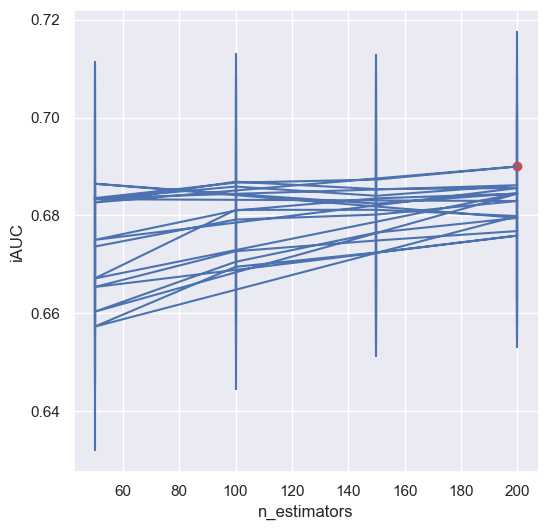

In [33]:
_, axs = plt.subplots(1, 1, figsize=(6, 6), sharex=True)
axs.set_xlabel("n_estimators")
plot_grid_search_results(gcv_iauc, axs, "iAUC","n_estimators")

In [34]:

risk_scores = gcv_iauc.best_estimator_.predict(X_train_scale)
print(concordance_index_censored(y_train["event_observed"],y_train["event_max"],risk_scores))
print(concordance_index_ipcw(y_train,y_train,risk_scores,tau=365))

(0.8231104759493612, 4174548, 897126, 0, 23675)
(0.8248735674179039, 4174548, 897126, 0, 23675)


In [35]:
rsf_auc, rsf_mean_auc,times = calc_dyn_auc(gcv_iauc.best_estimator_.estimator_,X_train_scale,y_train,y_train)

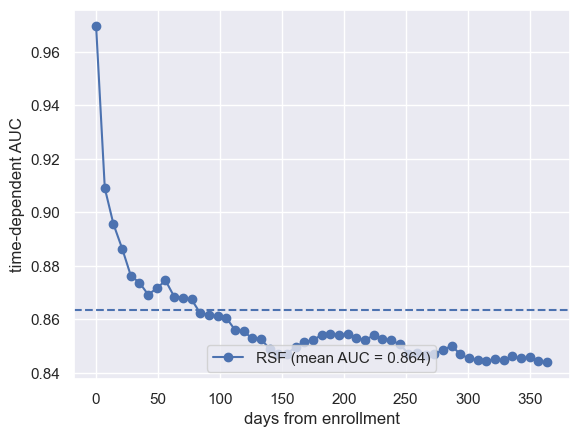

In [36]:
#plt.plot(va_times, cph_auc, "o-", label=f"CoxPH (mean AUC = {cph_mean_auc:.3f})")
plt.plot(times, rsf_auc, "o-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.axhline(rsf_mean_auc, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)

In [38]:
from pickle import dump
n_features= 94
with open("model/rf_event_max_gridsearch_{}.pkl".format(n_features), "wb") as f:
    dump(gcv_iauc, f, protocol=5)

In [59]:
from sklearn.inspection import permutation_importance

result = permutation_importance(gcv_iauc.best_estimator_, 
                                X_train_scale, y_train, n_repeats=5, random_state=random_state,n_jobs=4)

In [60]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_train_scale.columns,
).sort_values(by="importances_mean", ascending=False).to_csv("results/rf_full_feature_importance_{}.csv".format(n_features))

In [61]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_train_scale.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
creatinine,0.026807,0.002435
kccq_summ_bl,0.026242,0.003070
age,0.023044,0.001855
haemoglobin,0.022765,0.002340
weight,0.019259,0.001002
albumin,0.017716,0.002609
av_area_tte,0.012213,0.000729
height,0.011976,0.000688
annulus_area_ctaort,0.011433,0.001299
platelet_count,0.011122,0.000529


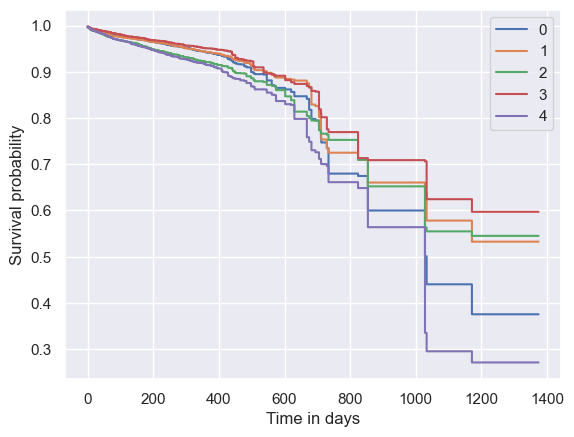

In [60]:
surv = clf.best_estimator_.predict_survival_function(X_train_scale.iloc[:5,:], return_array=True)

for i, s in enumerate(surv):
    plt.step(clf.best_estimator_.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [61]:
clf.best_estimator_.decision_path(X_train_scale.iloc[:5,:])

(<5x47340 sparse matrix of type '<class 'numpy.int64'>'
 	with 29913 stored elements in Compressed Sparse Row format>,
 array([    0,    45,   100, ..., 47246, 47291, 47340]))